<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preloading-Modules-and-Functions" data-toc-modified-id="Preloading-Modules-and-Functions-1">Preloading Modules and Functions</a></span></li><li><span><a href="#Main-Problem" data-toc-modified-id="Main-Problem-2">Main Problem</a></span></li><li><span><a href="#Feature-Selection" data-toc-modified-id="Feature-Selection-3">Feature Selection</a></span></li><li><span><a href="#Classification-with--Logistic-Regression-Model" data-toc-modified-id="Classification-with--Logistic-Regression-Model-4">Classification with  Logistic Regression Model</a></span></li><li><span><a href="#Model-Evaluation" data-toc-modified-id="Model-Evaluation-5">Model Evaluation</a></span><ul class="toc-item"><li><span><a href="#Confusion-table" data-toc-modified-id="Confusion-table-5.1">Confusion table</a></span></li><li><span><a href="#K-S-Chart" data-toc-modified-id="K-S-Chart-5.2">K-S Chart</a></span></li><li><span><a href="#ROC-Chart" data-toc-modified-id="ROC-Chart-5.3">ROC Chart</a></span></li></ul></li></ul></div>

## Preloading Modules and Functions

In [139]:
# For using data structures
import pandas as pd
# Ploting the graphs
import matplotlib.pyplot as plt
# Numerical computing of array and matrix
import numpy as np
# Split Data into Train and test datasets
from sklearn.model_selection import train_test_split
# smf.logit for logistic regression
import statsmodels.api as smf 
# add intercept term for logistic regression model.
from statsmodels.tools.tools import add_constant 

**confusionTable(X_Train,Y_Train,Prob_Train, cutoff=0.5)**  is the function to calculate the confusion table 

- input:
    - X_Train: Predictors
    - Y_Train: real Y value
    - Prob_Train: Probability of success (Y=1) computed from logistic regression model
    - cutoff: the threshold of probaility, above which, the individual is predicted to be y=1
- output:
    - The confusion table 

In [140]:
def confusionTable(X_Train,Y_Train,Prob_Train, cutoff=0.5):
    # Assign '1' to 'Pred_Train' if the associated prob of success > cutoff
    # Assign '0' to 'Pred_Train' if the associated prob of success <= cutoff
    Pred_Train=[1 if x>cutoff else 0 for x in Prob_Train]
    
    # Assign the True Negative(TN), False Negative(FN), False Positive(FP), True Positive(TP) to the table
    confusion_train=pd.crosstab(np.array(Pred_Train),Y_Train)
    
    # Compute the Positive Predictive Value(PPV) = TP/(FP+TP)
    PPV=confusion_train.iloc[1,1]/(confusion_train.iloc[1,1]+confusion_train.iloc[1,0])
    # Compute the Negative Predictive Value(NPV) = TN/(FN+TN)
    NPV=confusion_train.iloc[0,0]/(confusion_train.iloc[0,0]+confusion_train.iloc[0,1])
    # Compute the Accuracy = (TP+TN)/(TP+FP+FN+TN)
    accuracy=(confusion_train.iloc[1,1]+confusion_train.iloc[0,0])/(confusion_train.iloc[0,0]+confusion_train.iloc[0,1]+confusion_train.iloc[1,1]+confusion_train.iloc[1,0])
    # Add a new column 'PV' with two values: NPV, PPV
    confusion_train['PV']=[NPV,PPV]
    
    # Compute the Specificity = TN/(FP+TN)
    FPR=confusion_train.iloc[1,0]/(confusion_train.iloc[1,0]+confusion_train.iloc[0,0])
    # Compute the Sensitivity = TP/(TP+FN)
    TPR=confusion_train.iloc[1,1]/(confusion_train.iloc[1,1]+confusion_train.iloc[0,1])
    # Add a new row 'SS' with three values: Specificity, Sensitivity, Accuracy
    confusion_train.loc['PR']=[FPR, TPR,accuracy]
    
    return confusion_train

**KS_chart(Y_Train,Prob_Train,fgsize=6)**  is the function to plot KS chart.

- input:
    - Y_Train: real Y value
    - Prob_Train: Probability of success (Y=1) computed from logistic regression model
    - fgsize: The size of the figure
- output:
    - The KS chart, The KS Measure, The Cutoff Probability

In [141]:
def KS_chart(Y_Train,Prob_Train,fgsize=6):
    # Build a DataFrame 'df' storing 'Prob_Train' and 'Y_Train' for further usage.
    df=pd.DataFrame()
    df["Prob"]=Prob_Train
    df["realY"]=Y_Train
    
    # Reorder the rows of DataFrame 'df' in descending order according to the values in 'Prob'
    sortPro=df.sort_values(['Prob'],ascending=False)
   
    
    sortPro['TPR']=[sortPro.loc[:i,'realY'].sum()/(sortPro['realY']).sum() for i in sortPro.index]
    # Percentage of Negative Case(PNC)
    sortPro['FPR']=[(sortPro.loc[:i,'realY'].shape[0]-sortPro.loc[:i,'realY'].sum())/((sortPro['realY']).shape[0]-sortPro['realY'].sum() )  for i in sortPro.index]
    # PNC-PPC
    sortPro['K-S']=(1-sortPro['FPR'])-(1- sortPro['TPR'])
    
    # The largest absolute value in 'K-S'
    KS_measure=np.abs(sortPro['K-S'][:]).max()
    # The Cutoff probability that achieve KS Measure
    cutoff=sortPro.loc[sortPro["K-S"].idxmax(),"Prob"]
    # KS Measure: The largest value in 'K-S'
    ks_measure=sortPro["K-S"].max()
    
    ###################################### Plot the KS Chart ################################################
    # The size of the chart
    plt.figure(figsize=(fgsize,fgsize))
    # Plot the Percentage of Positive Case(PPC) with Red colour
    plt.plot(sortPro["Prob"], 1-sortPro['TPR'][:],'.-',color="red", label="1-TPR")
    # Plot the Percentage of Negative Case(PNC) with Green colour
    plt.plot(sortPro["Prob"],  1-sortPro['FPR'][:],'.-',color="green",label="1-FPR")
    
    #plt.plot([0,1],[0,1],color='red')
    
    # The x-axis label
    plt.xlabel('Cutoff Prob',size=20)
    # The title of the KS Chart with KS Measure 
    plt.title('KS_chart with ks_measure  '+str(ks_measure),size=30)
    # Set the x-axis limits
    plt.xlim(0,1)
    # Set the y-axis limits
    plt.ylim(0,1)
    plt.legend()
    #section = np.arange(-1, 1, 1/20.)
    #plt.fill_between(sortPro['Negative'][:], sortPro['Positive'][:], color=color )
    
    # Display the KS Chart
    plt.show()
    # Print the cutoff probability that achieve KS Measure
    print("KS_measure is achieved when the cutoff probability is ",cutoff )
   
    
    return ks_measure,cutoff

**RocCurve(Y_Train,Prob_Train,size=6,color='pink')**  is the function to plot RoC with Area Under Curve(AUC).

- input:
    - Y_Train: real Y value
    - Prob_Train: Probability of success (Y=1) computed from logistic regression model
    - size: The size of the figure
    - color: The color of the Area Under Curve(AUC)
- output:
    - The RoC with Area Under Curve(AUC)
    - Value of Area Under Curve(AUC)

In [142]:
def RocCurve(Y_Train,Prob_Train,size=6,color='pink'):
    # Build a DataFrame 'df' storing 'Prob_Train' and 'Y_Train' for further usage.
    df=pd.DataFrame()
    df["Prob"]=Prob_Train
    df["realY"]=Y_Train
    
    # Reorder the rows of DataFrame 'df' in ascending order according to the value in 'Prob'
    sortData=df.sort_values(['Prob'])
    
    # True Positive Rate(TPR) = Sensitivity = TP/(TP+FN)
    sortData['TP']=[sortData.loc[i:,'realY'].sum()/sortData['realY'].sum() for i in sortData.index]
    # False Positive Rate(FPR) = 1-Specificity = FP/(FP+TN)
    sortData['FP']=[(sortData.loc[i:,'realY'].shape[0]-sortData.loc[i:,'realY'].sum())/(sortData.shape[0]-sortData['realY'].sum()) for i in sortData.index]
    # For calculating the Area Under Curve(AUC)
    sortData['trapzoid']=0.5*(sortData['TP'].shift(-1)+sortData['TP'])*(sortData['FP']-sortData['FP'].shift(-1))
    # Area Under Curve(AUC) = The sum of values of 'trapzoid'
    AUC=sortData['trapzoid'].dropna().sum() 
    
    ###################################### Plot the RoC with AUC Chart ###########################################
    # Size of the chart
    plt.figure(figsize=(size,size))
    # x-axis: FPR, y-axis: TPR
    plt.plot(sortData['FP'][:], sortData['TP'][:],'.-')
    # Draw a reference line from (0,0) to (1,1)
    plt.plot([0,1],[0,1],color='red')
    # The x-axis label
    plt.xlabel('False Positive Rate',size=20)
    # The y-axis label
    plt.ylabel('True Positive Rate',size=20)
    # The title of the RoC with AUC Chart with the value of AUC 
    plt.title('ROC curve with AUC  '+str(AUC),size=30)
    # Set the x-axis limits
    plt.xlim(0,1)
    # Set the y-axis limits
    plt.ylim(0,1)
    
    #section = np.arange(-1, 1, 1/20.)
    
    # Fill the area
    plt.fill_between(sortData['FP'][:], sortData['TP'][:], color=color )
    # Display the RoC with AUC Chart
    plt.show()
    
    return AUC

**ReadData(Path,Yname)**  is the function to read the data set.

- input:
    - Path: The path of the data set
    - Yname: The column's name of the response
- output:
    - Data of predictors
    - Data of response

In [143]:
def ReadData(Path,Yname):
    # Read the data set
    Data = pd.read_csv(Path)
    # Assign the data of response to 'Y_Data'
    Y_Data=Data[Yname]
    # Assign the data of predictors to 'X_Data'
    X_Data=Data.drop(columns=Yname)
    
    return X_Data,Y_Data
    

**FeatureSelection(X_Train,Y_Train,X_Test,Y_Test, Top=20, corr_cut=95)**  is the function to select the predictors.
- input:
    - X_Train: Predictors (Training Set)
    - Y_Train: Response (Training Set)
    - X_Test: Predictors (Test Set)
    - Y_Test: Response (Test Set)
    - Top: Number of predictors to consider
    - corr_cut: The cutoff correlation
- output:
    - Training Set of Predictors after selection
    - Training Set of Response
    - Test Set of Predictors after selection
    - Test Set of Response

In [144]:
def FeatureSelection(X_Train,Y_Train,X_Test,Y_Test, Top=20, corr_cut=0.95):
    # Build a DataFrame 'data' storing 'Y_Train' and 'X_Train' for further usage.
    data=pd.DataFrame()
    data["realY"]=Y_Train
    data[X_Train.columns]=X_Train
    
    # The absolute value of the correlation between the predictors and response
    # Select the predictors that the values of correlation are the toppest 20
    # Assign the associated index to 'topfeature'
    topfeature=np.abs(data.corr()["realY"]).sort_values(ascending=False).iloc[1:Top+1].index 
    
    # The correlation of the 20 predictors in 'topfeature'
    M=X_Train[topfeature].corr()
    # Empty list for storage the column's name of the dropped predictors 
    droplist=[]
    
    for i in range(M.shape[0]):
        for j in range(i):
            # if the abs. correlation of a particular pair of predictors > 0.95, assign one of them to 'droplist'
            if M.iloc[i,j]>corr_cut or M.iloc[i,j]<-corr_cut:
                if topfeature[i] not in droplist and topfeature[j] not in droplist:
                    droplist.append(topfeature[i])

    return X_Train[topfeature].drop(columns=droplist),Y_Train,X_Test[topfeature].drop(columns=droplist),Y_Test

    
    

## Main Problem
In this topic, ee will use [Census Income Dataset](https://archive.ics.uci.edu/ml/datasets/adult) to predict whether an individual's income exceeds $50K/yr based on census data.

In [145]:
# Assign the data of predictors to 'X_Data'
# Assign the data of response to 'Y_Data'
X_Data,Y_Data =ReadData("classification_data/encoded_data.csv", "realY")

# Print the shape of 'X_Data' and 'Y_Data'
print(X_Data.shape,Y_Data.shape)

(29792, 83) (29792,)


"realY"is the variable name  we try to predict: 

- realY=0 : the income is below $50K/yr

- realY=1 : the income is above $50K/yr





We have 29792 individual records (data size) and 83 predictors.  We will separate (X_Data, Y_Data) into (X_Train,Y_Train)and (X_Test, Y_Test) for the purpose of evaluation. 

In [146]:
# Imported train_test_slit from sklearn module. 
# test_size: the proportion of the dataset to include in the test split.
# random_state: random seed = 42
X_Train, X_Test, Y_Train, Y_Test = train_test_split(X_Data, Y_Data, test_size=0.2, random_state=42)
print("For Train: ", X_Train.shape, Y_Train.shape)
print("For Test: ", X_Test.shape,Y_Test.shape)

For Train:  (23833, 83) (23833,)
For Test:  (5959, 83) (5959,)


## Feature Selection


There is a final step we need to complete before we build prediction model, **feature selection**:

- We first selection predictors who have high correlation with outcome variable "realY"

- If any pair of selected predictors are highly correlated, i.e. correlation>0.95 or <-0.95, we need to delete one of them. 

We save all steps in the Function: **FeatureSelection(X_Train,Y_Train,X_Test,Y_Test, Top=20, corr_cut=0.95)**. Check the details of codes if you are interested. 


In [147]:
X_Train,Y_Train,X_Test,Y_Test=FeatureSelection(X_Train,Y_Train,X_Test,Y_Test, Top=20, corr_cut=0.95)

In [148]:
# Print the names of the selected predictors
print(X_Train.columns,X_Train.shape)

Index(['marital-status_Married', 'relationship_ Husband',
       'marital-status_Never-Married', 'age_(16.927, 24.3]',
       'relationship_ Own-child', 'sex_ Female', 'education-num_(14.5, 16.0]',
       'capital-loss_(1742.4, 2613.6]', 'relationship_ Not-in-family',
       'occupation_Office Labour', 'occupation_Professional',
       'education-num_(8.5, 10.0]', 'education_Bachelors',
       'education-num_(13.0, 14.5]', 'occupation_Service',
       'hours-per-week_(40.2, 50.0]', 'education-num_(11.5, 13.0]',
       'education_Dropout'],
      dtype='object') (23833, 18)


We first select 20 predictor who have the highest correlation with Outcome variable in **Train set**. With  corr_cut=0.95, we can cut two more predictors who have more absolute correlation=0.95 with other predictors.   

## Classification with  Logistic Regression Model

- Logistic regression is designed as a binary classifier (output say {0,1}) but actually outputs the probability that the input instance is in the “1” class. 


$$
P(Y=1|x_1,x_2,\ldots x_k)=\frac{1}{1+exp(-(\beta_0+\beta_1x_1\ldots+\beta_kx_k))}
$$
Predictors of Logistic regression can be discrete or continuous, or categorical.  
$$
\frac{p}{1-p}
$$
is the "odds ratio"
$$log(\frac{p}{1-p})=\beta_0+\beta_1x_1\ldots+\beta_kx_k$$
is called log odds ratio or logit.

**Important:** by default, logistic  regression of statsmodels will **NOT include intercept**. if you want to add intercept in the regression, you need to use **statsmodels.tools.add_constant to add constant** in the X_Train

In [149]:
X_Train=add_constant(X_Train)
X_Test=add_constant(X_Test)

In [150]:
X_Train.shape

(23833, 19)

In [151]:
# Display the first five rows
X_Train.head()

,const,marital-status_Married,relationship_ Husband,marital-status_Never-Married,"age_(16.927, 24.3]",relationship_ Own-child,sex_ Female,"education-num_(14.5, 16.0]","capital-loss_(1742.4, 2613.6]",relationship_ Not-in-family,occupation_Office Labour,occupation_Professional,"education-num_(8.5, 10.0]",education_Bachelors,"education-num_(13.0, 14.5]",occupation_Service,"hours-per-week_(40.2, 50.0]","education-num_(11.5, 13.0]",education_Dropout
15866,1.0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
12036,1.0,1,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0
5474,1.0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
12471,1.0,1,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0
16992,1.0,0,0,1,0,0,0,0,0,1,0,1,0,1,0,0,0,1,0


In [152]:
# Build a logistic regression model
incomeLg=smf.Logit(Y_Train,X_Train).fit()

Optimization terminated successfully.
         Current function value: 0.364712
         Iterations 9


In [154]:
# Display the summary of the logistic regression model 'incomeLg'
# alpha: significance level
incomeLg.summary(alpha=0.05)

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  realY   No. Observations:                23833
Model:                          Logit   Df Residuals:                    23814
Method:                           MLE   Df Model:                           18
Date:                Thu, 24 Sep 2020   Pseudo R-squ.:                  0.3520
Time:                        21:42:30   Log-Likelihood:                -8692.2
converged:                       True   LL-Null:                       -13414.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                            -2.3886      0.128    -18.657      0.000      -2.639      -2.138
marital-status_Married            2.6149      0.104     25.115      0.000       2.411       2.819
relationship_ Husband            -0.8015      0.101     -7.967      0.000      -0.999      -0.604
marital-status_Never-Married     -0.6029      0.082     -7.365      0.000      -0.763      -0.442
age_(16.927, 24.3]               -1.9112      0.158    -12.116      0.000      -2.220      -1.602
relationship_ Own-child          -0.9455      0.167     -5.658      0.000      -1.273      -0.618
sex_ Female                      -0.6512      0.078     -8.379      0.000      -0.803      -0.499
education-num_(14.5, 16.0]        1.8643      0.137     13.558      0.000       1.595       2.134
capital-loss_(1742.4, 2613.6]     1.6237      0.105     15.486      0.000       1.418       1.829
relationship_ Not-in-family       0.3097      0.097      3.206      0.001       0.120       0.499
occupation_Office Labour          0.7954      0.045     17.680      0.000       0.707       0.884
occupation_Professional           0.5669      0.065      8.690      0.000       0.439       0.695
education-num_(8.5, 10.0]        -0.3627      0.087     -4.191      0.000      -0.532      -0.193
education_Bachelors               0.6854      0.106      6.473      0.000       0.478       0.893
education-num_(13.0, 14.5]        1.0795      0.111      9.715      0.000       0.862       1.297
occupation_Service               -0.8168      0.109     -7.467      0.000      -1.031      -0.602
hours-per-week_(40.2, 50.0]       0.4331      0.044      9.853      0.000       0.347       0.519
education-num_(11.5, 13.0]       -0.0853      0.128     -0.669      0.504      -0.335       0.165
education_Dropout                -1.4593      0.117    -12.487      0.000      -1.688      -1.230
=================================================================================================
"""

Next we will calculate the probability for realY=1 in Train and Test datasets. The values we predict and output from the model is the **probability**. 

In [172]:
X_Train.shape, X_Test.shape

((23833, 19), (5959, 19))

In [132]:
Prob_Train=incomeLg.predict(X_Train)
Prob_Test=incomeLg.predict(X_Test)

In [156]:
logodds=np.log(Prob_Train/(1-Prob_Train))

## Model Evaluation

### Confusion table

In [166]:
confusion_Train=confusionTable(X_Train,Y_Train,Prob_Train, cutoff=0.5)
print("Train:")
confusion_Train

Train:


realY,0,1,PV
row_0,,,
0,16453.000000,2797.000000,0.854701
1,1411.000000,3172.000000,0.692123
PR,0.078986,0.531412,0.823438


In [167]:
confusion_Test=confusionTable(X_Test,Y_Test,Prob_Test, cutoff=0.5)
print("Test:")
confusion_Test

Test:


realY,0,1,PV
row_0,,,
0,4105.000000,705.000000,0.853430
1,346.000000,803.000000,0.698869
PR,0.077735,0.532493,0.823628


### K-S Chart

KS chart of Train (23833,)


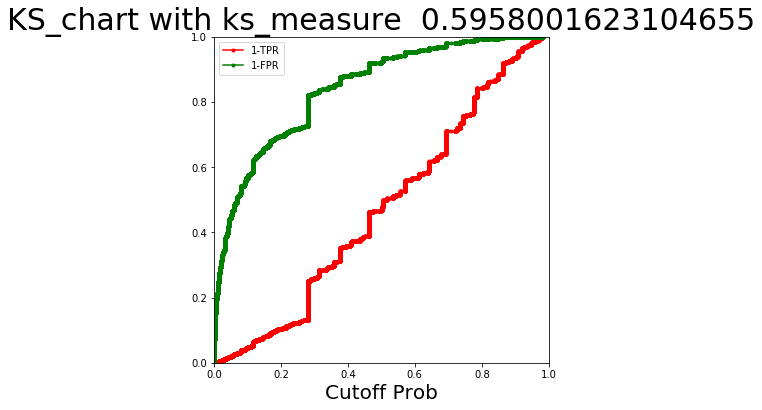

KS_measure is achieved when the cutoff probability is  0.25318480402318067


(0.5958001623104655, 0.25318480402318067)

In [175]:
print("KS chart of Train", Y_Train.shape)
KS_chart(Y_Train,Prob_Train)

KS chart of Test (5959,)


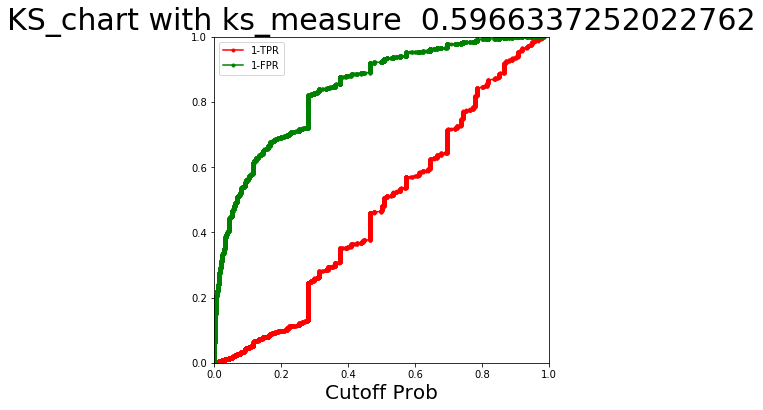

KS_measure is achieved when the cutoff probability is  0.25318480402318067


(0.5966337252022762, 0.25318480402318067)

In [173]:
print("KS chart of Test", Y_Test.shape)
KS_chart(Y_Test,Prob_Test)

### ROC Chart 

ROC curve of Train


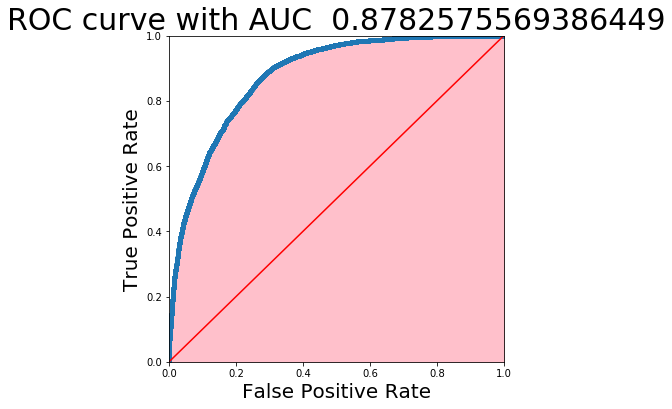

0.8782575569386449

In [170]:
print("ROC curve of Train")
RocCurve(Y_Train,Prob_Train)

ROC curve of Test


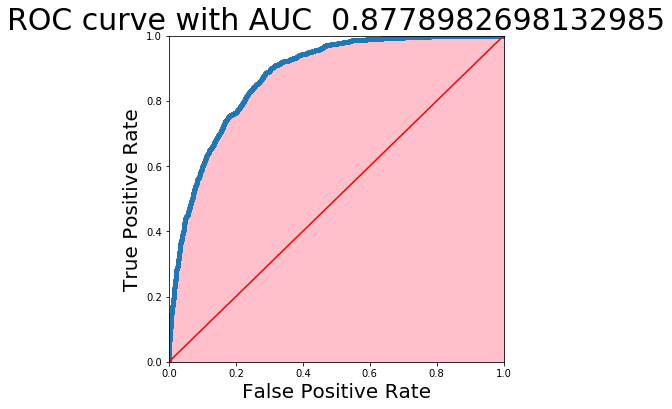

0.8778982698132985

In [171]:
print("ROC curve of Test")
RocCurve(Y_Test,Prob_Test)

$$
\beta_0,\beta_1,\ldots,\beta_k \mbox{ are parameters of logit model}
$$